# Learning to Sample Ray Paths for Faster Ray Tracing

In this notebook, we present a Machine Learning model,
based on the GFlowNet architecture {cite}`gflownet`,
that tries to learn how to sample valid ray paths
to reduce the overall computational complexity of Ray Tracing (RT).

Our model also takes inspiration from the Deep Sets
{cite}`deepsets` to provide invariance with permutations in the input,
as well as allowing the scene to be arbitrary large.

:::{note}
When writing this notebook and the Machine Learning Model,
we took a great inspiration from the [GFlowNet tutorial from Emmanuel Bengio](https://colab.research.google.com/drive/1fUMwgu2OhYpQagpzU5mhe9_Esib3Q2VR).
:::

:::{warning}
This notebook only shows a basic implementation of our model,
which may not yield the best performances.

Some discussions are provided at the end to suggest further
improvements.
:::

## Introduction

When modeling radio propagations, RT is often used as a mean to evaluate of the trajectories
that some radio waves can take to reach a given receiving antenna (RX), as emitted from a
transmitting antenna (TX).

With deterministic RT, also known as Point-to-Point (P2P) RT, we are interested
in listing **all the possible physically valid ray paths** from TX to RX,
that undergo up-to a fixed number of interaction, referred to as `order` in the code.

After pre-processing the input scene, tracing those paths is usually a two-steps process:

1. listing all possible path candidates between TX and RX;
2. and for each path candidate, (a) tracing the physical path, and (b) removing paths that
   are physically invalid (e.g., intersecting with any other object in the scene).

In many applications, we can represent each path candidate as
an ordered list of object indices :cite:`mpt-eucap2023,sionnart`,
where each index indicates on which object the path should *interact* with.

E.g., in the restricted context of specular reflections on flat walls,
`path_candidate = [A, C, D]` indicates a path that undergoes 3 *reflections* between
TX anx RX. The first one is on wall `A`, then the second is on wall `C`, and the
third on wall `6`. Using this order sequence of wall indices, we can then easily
construct the geometrical path of the ray, using, e.g., the image method.

In [1]:
# A few importants imports to be able to run our code
# 'type hint' related imports are only here for help documenting the code!

from collections.abc import Iterator

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from beartype import beartype as typechecker
from jaxtyping import Array, Float, Int, PRNGKeyArray, jaxtyped
from tqdm.notebook import trange

from differt2d.geometry import ImagePath, Point, Wall
from differt2d.logic import is_true
from differt2d.scene import Scene

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Motivations

When performing P2P RT, enumerating all possible path candidates is usually the
step that takes the most time, as the number of possible path candidates is in
the order of $\mathcal{O}(\texttt{num_walls}^\texttt{order})$. In large scenes,
this number can become dramatically large. However, this number can be largely decreased
if one knows the visibility matrix (or visibility tree, :cite:`visbilitytree`) of the scene,
but such a matrix is not really easy too obtain (and can be also very costly
to generate).

However, not all path candidates will lead a valid geometrical ray paths.
As such, **our model aims at directly sampling the path candidates that are
very likely to produce a valid ray path**, in order to reduce the overall complexity.

### A basic scene with all valid ray paths

To illustrate our motivations, we will first plot all the
valid second-order (`order=2`) ray paths in a basic scene
with one square obstacle.

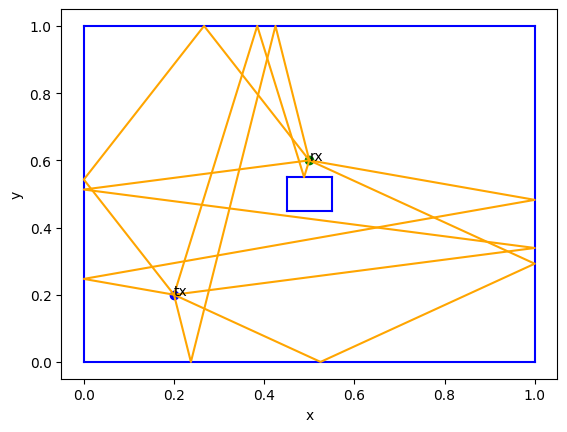

In [2]:
ax = plt.gca()
scene = Scene.square_scene_with_obstacle()
scene.plot(ax)

order = 2

for _, _, path, _ in scene.all_valid_paths(order=order):
    path.plot(ax)

xlim = plt.xlim()
ylim = plt.ylim()

plt.xlabel("x")
plt.ylabel("y")
plt.show()

### A basic scene with all valid and invalid ray paths

In the above figure, we only showed *valid* ray paths.
But what would happen if we also showed the *invalid* ones,
i.e., the geometrical paths as generated by path candidates
that **did not lead** to a valid path?

This is what we show in the next cell.

Found 6 valid path candidates, and 50 invalid path candidates,
which translates to 10.71% of path candidates being valid.


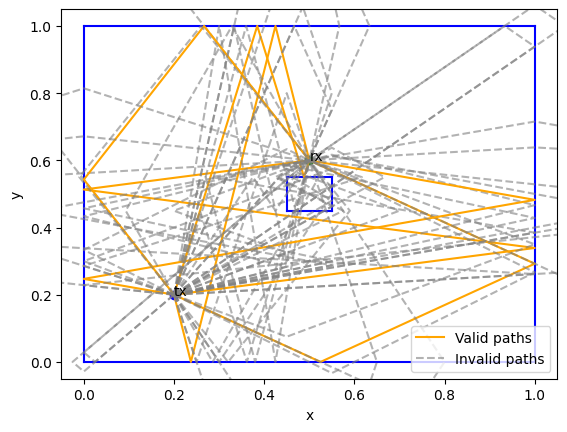

In [3]:
ax = plt.gca()
scene.plot(ax)

num_valid_path_candidates = 0
num_invalid_path_candidates = 0

for _, _, valid, path, _ in scene.all_paths(min_order=order, max_order=order):
    if is_true(valid):
        num_valid_path_candidates += 1
        (v,) = path.plot(ax)
    else:
        num_invalid_path_candidates += 1
        (i,) = path.plot(ax, linestyle="--", color="grey", alpha=0.6)

v.set_label("Valid paths")
i.set_label("Invalid paths")
ratio = num_valid_path_candidates / (num_valid_path_candidates + num_invalid_path_candidates)

print(
    f"Found {num_valid_path_candidates} valid path candidates, "
    f"and {num_invalid_path_candidates} invalid path candidates,\n"
    "which translates to "
    f"{100 * ratio:.2f}% "
    "of path candidates being valid."
)

plt.xlim(*xlim)
plt.ylim(*ylim)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

As you can see, only **a small fraction** of the path candidates result
in valid ray paths (orange solide lines).

For sure, this fraction can change with respect with the input scenem
but our model's hypothesis is that the number valid paths is usually
much smaller than the total number of path candidates.

## Model's goals

As described above, our model should take **as input**:
1. the TX coordinates;
2. the RX coordinates;
3. and an **unordered sequence** of **arbitrary many** objects.

We restrict objects to be each represented by the same number of coordinates.

E.g., all objects are 2D walls, each uniquely identified by $2\times 2$ coordinates.

The **output** should be a high-reward[^1] path candidate that undergoes
`order` interaction with the scene's objects. To obtain more path candidates, we should simply query the
model multiple times.

[^1]: Here, the reward is high if the path candidate leads to a physically valid ray path.

### Note about reproducibility

As we need randomness at various stages of this notebook,
to generate the training data,
to initialize the model's weights,
and to sample path candidates with our model,
we will first fix the random seed, the all the results below just
be reproducible locally, on any computer.

JAX is very different to NumPy, TensorFlow, and other array libraries, as it needs an explicit
*Pseudo Random Generator Key* for each random data generation. Other libraries usually have it
optional, and will work just fine by setting a `random.seed` at the very top of the project.

Because JAX aims to produce reproducible, parallelizable, and vectorisable results, you
**must** explicitly pass a PRNG key for each random numbers generation.

The best practice is then to start from one unique *seed* key, and split it
as many times as we need to generate random numbers. It is also best practice not
to reuse a PRNG key for two different random numbers generations.

For more details, read
[JAX's tutorial on pseudorandom numbers](https://jax.readthedocs.io/en/latest/random-numbers.html).

In [4]:
key = jax.random.PRNGKey(12345)  # 12345 is the 'random seed'
key, key_example_scene = jax.random.split(key, 2)

## Training data generation

For this example, we limit ourselves to the study of specular reflection paths
on straight walls. This is, **however**, not a limitation of our model.

We generate data by applying random modifications on the very basic
*square scene with obstacle*. The training data is simply a never ending
iterator, which makes it very convenient of we want to increase the number
of training steps.

As every training sample is different, there is not real need to have both
a training set and a test set. However, we will produce a validation set
that will evaluate our model on a, hopefully representative, set of scenes.

Also, the GFlowNet architecture has the advantage that we **do not** actually need
the have a ground truth. Indeed, we simply need to have some *reward function*
that evaluated some path candidate sampled by our model. Thus, this avoids
us to enumerate all possible paths during training[^2].

[^2]: As we will see in the [discussion](#discussion),
    precomputing all possible paths during
    training could help us skip scenes with no valid path, as it was observed
    that it could improve the overall model's performances.

In [5]:
def random_samples(
    min_ratio: float = 0.20,
    max_ratio: float = 0.40,
    min_num_walls: int = 4,
    min_angle: float = -0.1 * jnp.pi,
    max_angle: float = +0.1 * jnp.pi,
    *,
    key: PRNGKeyArray,
) -> Iterator[Float[Array, "2+num_walls*2 2"]]:
    """
    Returns a generator of random variants of :func:`Scene.square_scene_with_obstacle`.

    The generation follows a three-steps process:

    1. generate a ``square_scene_with_obstacle`` with a random scaling ratio;
    2. sample a random number of walls from this scene;
    3. and apply a random rotation around the scene's center for each wall.

    :param min_ratio: The minimum scaling ratio of the inner square obstacle.
    :param min_ratio: The maximum scaling ratio of the inner square obstacle.
    :param min_num_walls: The minimum number of walls to sample (maximum is 8).
    :param min_angle: The minimum rotation angle (random for each wall).
    :param max_angle: The maximum rotation angle (random for each wall).
    :param key: The random key to be used.
    :return: An iterator over xys samples
    """
    while True:
        key, key_ratio, key_tx_rx, key_num_walls, key_walls, key_angles = (
            jax.random.split(key, 6)
        )
        # A random scaling is applied to the inner square
        ratio = jax.random.uniform(key_ratio, minval=min_ratio, maxval=max_ratio)
        # TX and RX are randomly sampled
        points = jax.random.uniform(key_tx_rx, (2, 2))
        # The walls are samples from the scene
        scene = Scene.square_scene_with_obstacle(ratio=ratio)
        center = scene.center()
        indices = jnp.arange(len(scene.objects), dtype=jnp.int32)
        # The number of walls is random
        num_walls = jax.random.randint(
            key_num_walls, (), minval=min_num_walls, maxval=len(scene.objects) + 1
        )
        # Walls are shuffled (to make sure deepset models
        # is permutation invariant, but should not be needed)
        wall_indices = jax.random.choice(
            key_walls, indices, shape=(num_walls,), replace=False
        )
        # Each wall receives a random permutation around the center of the scene
        angles = jax.random.uniform(
            key_angles, shape=(num_walls,), minval=min_angle, maxval=max_angle
        )
        objects = [
            scene.objects[wall_index].rotate(angle=angle, around=center)
            for wall_index, angle in zip(wall_indices, angles)
        ]

        points = jnp.vstack([points, *[obj.xys for obj in objects]])

        yield points


@jax.jit
def sample_2_scene(xys: Float[Array, "2+num_walls*2 2"]) -> Scene:
    """
    Creates the scene corresponding to the given sample.

    :param xys: The sample as returned by :func:`random_samples`.
    :return: The corresponding scene.
    """
    tx = Point(xy=xys[0, :])
    rx = Point(xy=xys[1, :])

    walls = xys[2:].reshape(-1, 2, 2)
    walls = [Wall(xys=wall) for wall in walls]

    return Scene(transmitters={"tx": tx}, receivers={"rx": rx}, objects=walls)


samples = random_samples(key=key_example_scene)

=(random-scene-example)
### Example of random scene

Below, we can see one of the random scenes generated by our function defined just before.

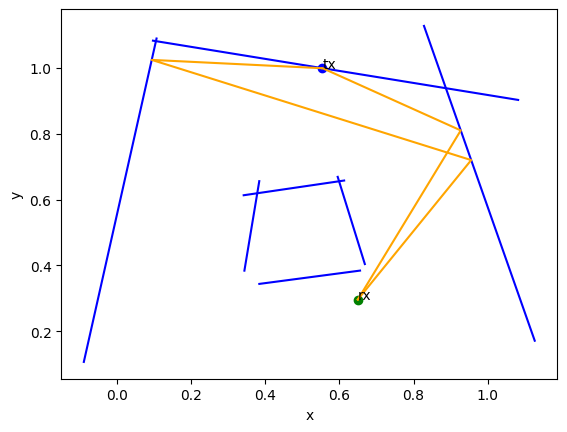

In [6]:
# Run this cell multiple times for different results!

ax = plt.gca()
scene = sample_2_scene(next(samples))
scene.plot(ax)

for _, _, path, _ in scene.all_valid_paths(order=order):
    path.plot(ax)

plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Training and validation samples

Because our data generation produces a never-ending sequence of
samples, each sample being unique, we can very well take the 100 first samples
and use them as a validation set.

Using 100 samples is a bit arbitrary, as it assumes that those 100
samples can be representative of the distribution of all possible
scenes. We will discuss that assumptions in the [discussion](#discussion)
section.

In [7]:
key, key_samples = jax.random.split(key, 2)

# Let's filter out the cases with not valid paths,
# because they are not interesting to learn from.

num_val_samples = 100

train_samples = random_samples(key=key_samples)

val_samples = [next(train_samples) for i in range(num_val_samples)]

## Reward function

To indicate our model which path candidates should be sampled
(and which paths should not), we define a *reward* function.

The goal of the reward function is to give a high reward to valid paths,
and and a low reward to invalid ones.

The simplest reward possible is the following: valid path candidates
receive a reward of 1, while invalid path candidates receive no reward.

In [8]:
@jax.jit
@jaxtyped(typechecker=typechecker)
def reward(
    pred_path_candidate: Int[Array, "order"],
    scene: Scene,
) -> Float[Array, " "]:
    """
    Rewards a predicted path candidate depending on if it
    produces a valid path in the given scene.

    :param pred_path_candidate: The predicted path candidate.
    :param scene: The scene in which the path is traced.
    :return: The (positive) reward.
    """
    tx = scene.transmitters["tx"]
    rx = scene.receivers["rx"]

    # The following it a JIT-compatible variant of scene.get_interacting_objects
    xys = jnp.stack(
        [wall.xys for wall in scene.objects]
    )  # Stack all walls into one array
    interacting_walls = jnp.take(xys, pred_path_candidate, axis=0)
    interacting_walls = [Wall(xys=wall) for wall in interacting_walls]

    path = ImagePath.from_tx_objects_rx(tx, interacting_walls, rx)
    valid = path.is_valid(scene.objects, pred_path_candidate, interacting_walls)

    return valid.astype(float)

Let us take a look at the rewards of the different path candidates from the above scene.

invalid: path_candidate = [0, 1] has a reward of 0.0
invalid: path_candidate = [0, 2] has a reward of 0.0
invalid: path_candidate = [0, 3] has a reward of 0.0
invalid: path_candidate = [0, 4] has a reward of 0.0
valid  : path_candidate = [0, 5] has a reward of 1.0
invalid: path_candidate = [0, 6] has a reward of 0.0
invalid: path_candidate = [1, 0] has a reward of 0.0
invalid: path_candidate = [1, 2] has a reward of 0.0
invalid: path_candidate = [1, 3] has a reward of 0.0
invalid: path_candidate = [1, 4] has a reward of 0.0
invalid: path_candidate = [1, 5] has a reward of 0.0
invalid: path_candidate = [1, 6] has a reward of 0.0
invalid: path_candidate = [2, 0] has a reward of 0.0
invalid: path_candidate = [2, 1] has a reward of 0.0
invalid: path_candidate = [2, 3] has a reward of 0.0
invalid: path_candidate = [2, 4] has a reward of 0.0
invalid: path_candidate = [2, 5] has a reward of 0.0
invalid: path_candidate = [2, 6] has a reward of 0.0
invalid: path_candidate = [3, 0] has a reward 

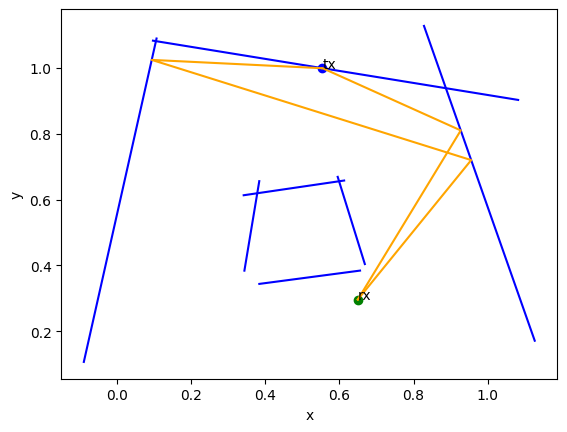

In [9]:
ax = plt.gca()
scene.plot(ax)

for _, _, valid, path, path_candidate in scene.all_paths(order=order):
    if is_true(valid):
        path.plot(ax)
        s = "valid  :"
    else:
        s = "invalid:"

    p = path_candidate.tolist()
    r = reward(path_candidate, scene)

    print(
        f"{s} path_candidate = {p} has a reward of {r}"
    )

plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Model definition

Our model follows the architecture of GFlowNet models: the goal is to **learn how sample path candidates**
(here, the final state of the flowchart) such that their sampling rate is proportional to their corresponding
reward.

A path candidate is simply a list of wall indices, e.g., `[A, C]`[^3]. A path candidate under
construction (i.e., not yet completed), is represented with `X` for undecided states.

[^3]: Numeric indices are replaced here with letters, to make it simpler. In practice, walls
    are identified based on a zero-based array indexing.

E.g., `path_candidate = [A, X]` indicates a path with 2 interactions, where the first
is already defined (i.e., wall `A`).

For each path candidate, either incomplete or complete, there is a unique state $s$ representing it. In the code, states
are obtained by encoding the corresponding path candidate using one-hot encoding.

E.g., the complete `path_candidate = [A, C]` is represented by the following state
(assuming 3 objects in the scene):

```python
state = [
  [1, 0],  # Wall A
  [0, 0],  # Wall B
  [0, 0],  # Wall C
]
```

While the incomplete `path_candidate = [A, X]` is represented by:

```python
state = [
  [1, 0],  # Wall A
  [0, 0],  # Wall B
  [0, 1],  # Wall C
]
```

The last column being all zeros refers to the `X`.

Below, the diagram of all possible states is shown. As interacting with the same
object twice in a row is **physically unsound**, this state is **unreachable** (dotted lines).
To account for that in the model, the flow is stopped to prevent reaching those states.

```{mermaid}
:align: center
:caption: Flowchart of all possible states for a 2-order path candidates in a scene with 3 walls.

flowchart TD
    ?(??) -->|"F(??, A?)"| A(A?)
    ? -->|"F(??, A?)"| B(B?)
    ? -->|"F(??, A?)"| C(C?)

    A -.-x|"F(A?, AA)"| AA(AA)
    A -->|"F(A?, AB)"| AB(AB)
    A -->|"F(A?, AC)"| AC(AC)

    B -->|"F(B?, BA)"| BA(BA)
    B -.-x|"F(B?, BB)"| BB(BB)
    B -->|"F(B?, BC)"| BC(BC)

    C -->|"F(C?, CA)"| CA(CA)
    C -->|"F(C?, CB)"| CB(CB)
    C -.-x|"F(C?, CC)"| CC(CC)
```

The construction of any path candidate start at the `??` state.
Then, the next state is chosen randomly, accordingly to the flow model,
see next the [loss function definition](#loss-function-definition) for more details.
For second order path candidates, this step is **repeated twice**.

The next flowchart indicate the construction of `path_candidate = [A, X]`.

```{mermaid}
:align: center
:caption: Flowchart of with edge leading to the construction of `[A, X]` highlighted.

flowchart TD
    ?(??) -->|"F(??, A?)"| A(A?)
    ? -->|"F(??, A?)"| B(B?)
    ? -->|"F(??, A?)"| C(C?)

    A -.-x|"F(A?, AA)"| AA(AA)
    A -->|"F(A?, AB)"| AB(AB)
    A -->|"F(A?, AC)"| AC(AC)

    B -->|"F(B?, BA)"| BA(BA)
    B -.-x|"F(B?, BB)"| BB(BB)
    B -->|"F(B?, BC)"| BC(BC)

    C -->|"F(C?, CA)"| CA(CA)
    C -->|"F(C?, CB)"| CB(CB)
    C -.-x|"F(C?, CC)"| CC(CC)
    
    linkStyle 0 stroke:#ff3,stroke-width:4px,background-color:lime;
```

Finally, the complete path candidate, here `[A, C]` is reached after a second call to our model.

```{mermaid}
:align: center
:caption: Flowchart of with edges leading to the construction of `[A, C]` highlighted.

flowchart TD
    ?(??) -->|"F(??, A?)"| A(A?)
    ? -->|"F(??, A?)"| B(B?)
    ? -->|"F(??, A?)"| C(C?)

    A -.-x|"F(A?, AA)"| AA(AA)
    A -->|"F(A?, AB)"| AB(AB)
    A -->|"F(A?, AC)"| AC(AC)

    B -->|"F(B?, BA)"| BA(BA)
    B -.-x|"F(B?, BB)"| BB(BB)
    B -->|"F(B?, BC)"| BC(BC)

    C -->|"F(C?, CA)"| CA(CA)
    C -->|"F(C?, CB)"| CB(CB)
    C -.-x|"F(C?, CC)"| CC(CC)
    
    linkStyle 0 stroke:#ff3,stroke-width:4px,background-color:lime;
    linkStyle 5 stroke:#ff3,stroke-width:4px,background-color:lime;
```

We therefore define two classes: `FlowModel`, that will learn the flow relationships between states,
and `Model`, that will use a trained `FlowModel` to generate a complete path candidate.

When combined, the process of generating, or sampling, path candidates can be
represented as in the following graph.

```{mermaid}
:align: center
:caption: Graph of the (simplified) sampling process, and other usual steps.

graph LR
    GE[[Geometry]]
    O[[order]]
    FM((Flow<br>model))
    PT(Path tracing)
    PP(Path post-processing)
    EM(EM Fields)

    subgraph Model
        FM  
    end

    FM--> |order times| FM
    GE --> Model
    O --> Model
    Model -->|"Path candidate"| PT
    PT -->|"Ray path"| PP
    PP -->|"Valid ray path"| EM
```

In [10]:
class FlowModel(eqx.Module):
    """The flow model that returns flows between two states."""

    # Layers
    wall_2_embeddings: eqx.nn.MLP
    """MLP that is applied to each wall in parallel and
    returns the corresponding embeddings."""
    embeddings_2_flow: eqx.nn.MLP
    """MLP that maps each possible choice to some positive flow."""

    def __init__(
        self,
        # Hyperparameters
        num_embeddings: int = 100,
        *,
        key: PRNGKeyArray,
    ):
        """
        Constructs a GFlowNet model.

        :param num_embeddings: The size of the vector that will represent each wall.
        :param key: The random key to be used.
        """
        key1, key2 = jax.random.split(key, 2)

        # Layers
        self.wall_2_embeddings = eqx.nn.MLP(
            in_size=4,
            out_size=num_embeddings,
            width_size=500,
            depth=3,
            key=key1,
        )
        self.embeddings_2_flow = eqx.nn.MLP(
            in_size=4
            + 2 * num_embeddings
            + 4,  # [tx_rx, state_embeddings, scene_embeddings, wall[i]]
            out_size="scalar",
            width_size=500,
            depth=3,
            final_activation=jnp.exp,  # Positive flow only
            key=key2,
        )

    @eqx.filter_jit
    @jaxtyped(typechecker=typechecker)
    def __call__(
        self,
        state: Float[Array, "num_walls order"],
        wall_index: Int[Array, " "],
        xys: Float[Array, "2+num_walls*2 2"],
    ) -> Float[Array, "num_walls"]:
        """
        Calls this model in order to generate a new flow from a given state,
        the last selected wall index, and some input scene.

        :param state: The current state, a one-hot encoding of the path candidate
            in construction. Only one element per column can be non-zero.
        :param wall_index: The index of the last wall that was selected. A negative index
            indicates that no wall was previously selected.
        :param xys: The array of xy-coordinates, as returned by
            :func:`random_samples`.
        :return: The array of flows, one per wall in the scene.
        """
        assert (
            xys.shape[0] >= 4
        ), "Scene must at least have two points, tx and rx, and one wall!"

        num_walls, order = state.shape

        # Data normalization
        eps = 1e-5
        mean = jnp.mean(xys, axis=0, keepdims=True)
        std = jnp.std(xys, axis=0, keepdims=True)

        xys = (xys - mean) / (std + eps)

        tx_rx = xys[:2, :].reshape(4)
        walls = xys[2:, :].reshape(num_walls, 4)

        # [num_walls 4]
        # note: this input we be the same for every wall
        tx_rx = jnp.tile(tx_rx, (num_walls, 1))

        # [num_walls num_embeddings]
        # note: each wall is mapped to a vector of embeddings
        walls_embeddings = jax.vmap(self.wall_2_embeddings)(walls)

        # [num_embeddings]
        # note: the scene is the sum of all embeddings
        scene_embeddings = jnp.sum(walls_embeddings, axis=0)

        # [num_walls num_embeddings]
        # note: this input we be the same for every wall
        scene_embeddings = jnp.tile(scene_embeddings, (num_walls, 1))

        # [order]
        # note: fill_value=num_walls is important as we need to generate 'out of bounds'
        #       indices for missing values (only current_order <= order are non zero)
        wall_indices, _ = jnp.nonzero(state, size=order, fill_value=num_walls)

        # [order num_embeddings]
        # note: we tell JAX to replace 'out of bounds' indices with zeros,
        #       as this will have no impact on the sum (see next step)
        state_embeddings = jnp.take(
            walls_embeddings, wall_indices, axis=0, fill_value=0
        )

        # [num_embeddings]
        # note: this contains information about the walls we already visited,
        #       as a sum of corresponding embeddings (one wall can appear multiple times)
        state_embeddings = jnp.sum(state_embeddings, axis=0)

        # [num_walls num_embeddings]
        # note: this input we be the same for every wall
        state_embeddings = jnp.tile(state_embeddings, (num_walls, 1))

        # [num_walls]
        # note: the input (per wall) looks as follows
        #       # [tx_rx, state_embeddings, scene_embeddings, wall[i]]
        flow = jax.vmap(self.embeddings_2_flow)(
            jnp.hstack((tx_rx, state_embeddings, scene_embeddings, walls))
        )

        # Set flow[wall_index] to zero to prevent consecutive duplicate indices
        # A flow of zero means that there is a zero probability to pick
        # walls[wall_index] for the next state.
        flow = flow.at[wall_index].set(0.0)  # out of bounds indices are ignored

        return flow


class Model(eqx.Module):
    """The generative model that samples a path candidate from flows."""

    flow: FlowModel
    """The learnable flow model."""

    @eqx.filter_jit
    def __call__(
        self,
        xys: Float[Array, "2+num_walls*2 2"],
        *,
        order: int,
        key: PRNGKeyArray,
    ) -> Int[Array, "{order}"]:
        """
        Calls this model to generate a path candidate of the given order.

        :param xys: The array of xy-coordinates, as returned by
            :func:`random_samples`.
        :param order: The order of the path candidate.
        :param key: The random key to be used.
        :return: A path candidate.
        """
        # See loss function for detailed comments
        num_walls = (xys.shape[0] - 2) // 2

        ScanR = Int[Array, " "]
        ScanC = tuple[
            Float[Array, " num_walls"],
            Float[Array, "num_walls order"],
        ]

        @jaxtyped(typechecker=typechecker)
        def scan_fn(
            carry: ScanC, key_and_current_order: tuple[PRNGKeyArray, Int[Array, " "]]
        ) -> tuple[ScanC, ScanR]:
            parent_edge_flow_prediction, state = carry
            key, current_order = key_and_current_order

            p = parent_edge_flow_prediction / jnp.sum(parent_edge_flow_prediction)

            wall_index = jax.random.categorical(key=key, logits=jnp.log(p))

            state = state.at[wall_index, current_order].set(1.0)

            edge_flow_prediction = self.flow(state, wall_index, xys)

            return (edge_flow_prediction, state), wall_index

        wall_index = jnp.array(num_walls)
        state = jnp.zeros((num_walls, order))
        parent_edge_flow_prediction = self.flow(state, wall_index, xys)
        init = parent_edge_flow_prediction, state
        _, pred_path_candidate = jax.lax.scan(
            scan_fn,
            init,
            xs=(jax.random.split(key, order), jnp.arange(order)),
        )

        return pred_path_candidate

## Loss function definition

A central property of GFlowNet models that, after successful training, the model should sample terminal states, i.e.,
complete path candidates, with a probability $p$, that is proportional to their corresponding reward, $R$.

In other words,

```{math}
p(\mathcal{P}) \propto R(\mathcal{P}),
```

where $\mathcal{P}$ is one possible path candidate, 

To reach this property, the model must have the following properties:

1. each edge must be assigned a positive flow, $F(s,s') > 0$, where $s$ is the parent state and $s'$ is the child state;
2. the flow consistency must be ensured:
   ```{math}
   \forall s', F(s,s') = R(s') + \sum_{s''}F(s',s''),
   ```
   that is, the sum of output flows, $F(s',s'')$, must be equal to the input flow, $F(s,s')$, minus the reward;
4. and
   ```{math}
   p(s'|s) = \frac{F(s,s')}{\sum_{s''}F(s,s'')},
   ```
   that is, the probability of choosing state $s'$ from state $s$.

Note that all states, except the terminal states, have a zero reward.

The following cell contains a lot of boilerplate code to generate multiple path
candidates for a given scene, and optionally plot the output in a nice way.

In [11]:
@jaxtyped(typechecker=None)
def loss(
    model: FlowModel,
    xys: Float[Array, "2+num_walls*2 2"],
    batch_size: int = 10,
    plot: bool = False,
    *,
    order: int,
    key: PRNGKeyArray,
) -> Float[Array, " "]:
    """
    Compute the loss of the model on a specific input scene.

    The loss is accumulated over the generation of 'batch_size' path candidates.
    """
    num_walls = (xys.shape[0] - 2) // 2
    scene = sample_2_scene(xys)

    ScanR = Int[Array, " "]
    ScanC = tuple[
        Float[Array, " "],
        Float[Array, " num_walls"],
        Float[Array, "num_walls order"],
    ]

    @jaxtyped(typechecker=typechecker)
    def scan_fn(
        carry: ScanC, key_and_current_order: tuple[PRNGKeyArray, Int[Array, " "]]
    ) -> tuple[ScanC, ScanR]:
        # We carry, for the currently generated path candidate:
        # - the flow mismatch (parent edges flow - current flow)
        # - the parent edge flow (only one parent leads to the current choice)
        # - the state (path candidate using one-hot encoding)
        flow_mismatch, parent_edge_flow_prediction, state = carry
        key, current_order = key_and_current_order

        # Turn positive flow into normalized probability in [0, 1]
        p = parent_edge_flow_prediction / jnp.sum(parent_edge_flow_prediction)

        wall_index = jax.random.categorical(
            key=key, logits=jnp.log(p)
        )  # The wall to choose

        # Indicate we have chosen walls[wall_index] as a candidate at 'current_order'
        state = state.at[wall_index, current_order].set(1.0)

        edge_flow_prediction = model(state, wall_index, xys)

        pred_path_candidate, _ = jnp.nonzero(state, size=order, fill_value=num_walls)

        flow_mismatch += jnp.where(
            current_order == order - 1,  # Check whether we reached final state
            (  # Reached last state so (next) edge_flow_prediction is ignored
                parent_edge_flow_prediction[
                    wall_index
                ]  # Each state s' has only one possible parent state s
                - reward(pred_path_candidate, scene)
            )
            ** 2,
            (  # Didn't reach last state so no reward
                parent_edge_flow_prediction[
                    wall_index
                ]  # Each state s' has only one possible parent state s
                - jnp.sum(edge_flow_prediction)
            )
            ** 2,
        )

        return (flow_mismatch, edge_flow_prediction, state), wall_index

    BatchC = Float[Array, " "]
    BatchR = Int[Array, " order"]

    @jaxtyped(typechecker=typechecker)
    def batch_fn(batch_loss: BatchC, key: PRNGKeyArray) -> tuple[BatchC, BatchR]:
        flow_mismatch = jnp.array(0.0)
        wall_index = jnp.array(
            num_walls
        )  # We didn't select any wall yet: out of bounds index
        state = jnp.zeros(
            (num_walls, order)
        )  # Same, but represented in one-hot encoding
        parent_edge_flow_prediction = model(
            state, wall_index, xys
        )  # Initial state's flow
        init = flow_mismatch, parent_edge_flow_prediction, state
        # Scan accumulates the mismatch and generated the path candidate
        (flow_mismatch, *_), pred_path_candidate = jax.lax.scan(
            scan_fn,
            init,
            xs=(jax.random.split(key, order), jnp.arange(order)),
        )

        return batch_loss + flow_mismatch, pred_path_candidate

    batch_loss = jnp.array(0.0)
    batch_loss, pred_path_candidates = jax.lax.scan(
        batch_fn, batch_loss, xs=jax.random.split(key, batch_size)
    )

    if plot:  # Let's see the prediction vs ground truth
        ax = plt.gca()
        scene.plot(ax)
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)
        tx = scene.transmitters["tx"]
        rx = scene.receivers["rx"]

        gt = None
        for _, _, path, _ in scene.all_valid_paths(order=order):
            (gt,) = path.plot(ax, color="orange")

        if gt is not None:
            gt.set_label("Ground Truth")

        n_unique = 0
        pr = None
        for pred_path_candidate in jnp.unique(pred_path_candidates, axis=0):
            n_unique += 1
            objects = [scene.objects[i] for i in pred_path_candidate]
            (pr,) = ImagePath.from_tx_objects_rx(tx, objects, rx).plot(
                ax, linestyle="--", alpha=0.5, color="red"
            )

        if pr is not None:
            pr.set_label("Prediction")

        plt.title(f"Generated {batch_size} path cand. (of which {n_unique} are unique)")
        plt.legend()
        plt.xlabel("x")
        plt.ylabel("y")
        plt.show()

    return batch_loss

### Evaluating the loss on an untrained model

The following code shows how to initialize the model and
how the loss function works. The order of paths must be specified
at this will tell the loss function how many times the flow model
should be called.

To change the order of the generated path candidates,
you just need to change the value of `order=1` keyword-only argument.

In [12]:
key, key_model = jax.random.split(key, 2)
untrained_model = FlowModel(key=key_model)

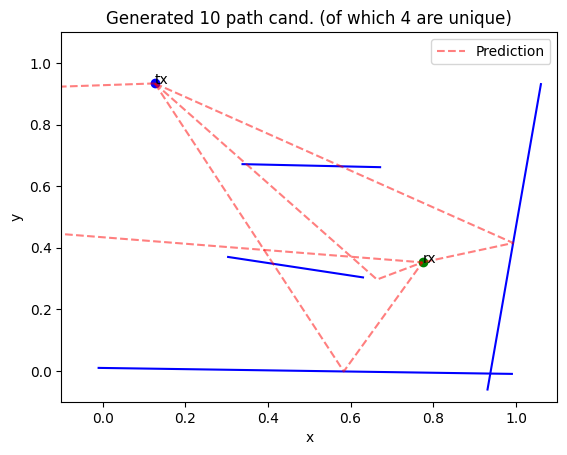

Array(9.760295, dtype=float32)

In [13]:
# Run this cell multiple times for different results!

key, key_loss_untrained = jax.random.split(key, 2)
loss(
    untrained_model, next(train_samples), plot=True, order=1, key=key_loss_untrained
)  # Untrained model

## Training phase

In the proposed architecture, only the `FlowModel` needs to be trained.

As a result, we defined a loss function directly deals with this model,
and not with the `Model` class, and the learning procedure looks a bit
like in the graph below.

```{mermaid}
:align: center
:caption: Graph of the (simplified) learning process.

graph LR
    GE[[Geometry]]
    PC((Flow<br>model))
    R(Reward)
    G(Gradients)

    subgraph Loss
        PC
        R
    end

    PC --> |order times| PC
    GE --> PC
    PC -->|"Path candidate"| R
    R --> |Loss| G
    G -->|Update| PC
```

The training function is very simple, as it the complex part
of performing the gradients update is done by {mod}`optax`.
We decide to use one of the most popular model, Adam {cite}`adam`,
but one could think of other optimizers (or meta-parameters)
that may be best suited to this problem!

In [14]:
optim = optax.adam(learning_rate=3e-5)

In [15]:
def train(
    model: FlowModel,
    train_samples: Iterator[Float[Array, "2+num_walls*2 2"]],
    val_samples: list[Float[Array, "2+num_walls*2 2"]],
    optim: optax.GradientTransformation,
    steps: int = 100_000,
    print_every: int = 100,
    *,
    order: int,
    key: PRNGKeyArray,
) -> tuple[FlowModel, Float[Array, "{steps}//{print_every}"], Float[Array, "{steps}//{print_every}"]]:
    """
    Trains a flow model on a sequence of training samples and returns the averaged loss over validation samples.

    :param model: The model to train.
    :param train_samples: The training samples.
    :param val_samples: The validation samples.
    :param optim: The optimizer to use.
    :param steps: The number of optimization steps.
    :param print_every: The frequency at which the average loss is computed.
    :param order: The order of the paths to be trained on.
    :param key: The random key to be used.
    :return: The trained model, the steps, and the losses.
    """
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(
        model: FlowModel,
        opt_state: optax.OptState,
        xys: Float[Array, "2+num_walls*2 2"],
        *,
        order: int,
        key: PRNGKeyArray,
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(
            model, xys, order=order, key=key
        )
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    loss_steps = []
    losses = []
    jitted_loss = eqx.filter_jit(loss)

    with trange(steps, desc="", unit=" steps", leave=True) as bar:
        for (
            step,
            xys_train,
        ) in zip(bar, train_samples):
            key, key_step = jax.random.split(key, 2)

            model, opt_state, train_loss = make_step(
                model, opt_state, xys_train, order=order, key=key_step
            )

            if (step % print_every) == 0 or (step == steps - 1):
                # Only update the training 'bar' every few steps
                val_loss = 0.0
                for xys_val in val_samples:
                    key, key_val = jax.random.split(key, 2)
                    val_loss += jitted_loss(model, xys_val, order=order, key=key_val)

                val_loss /= len(val_samples)

                loss_steps.append(step)
                losses.append(val_loss)

                bar.set_description(
                    f"train_loss = {float(train_loss):.1f}, "
                    f"val_loss = {float(val_loss):.1f}"
                )

    return model, jnp.array(loss_steps), jnp.array(losses)

### First order paths

Below, we show the training process for learning how to sample first-order
path candidates. As you can see from the plot of the loss function,
the learning is not excellent, but we can observe that the model
often returns valid path candidates, and that we don't just have
`batch_size=10` random path candidates that are all different.

  0%|          | 0/100000 [00:00<?, ? steps/s]

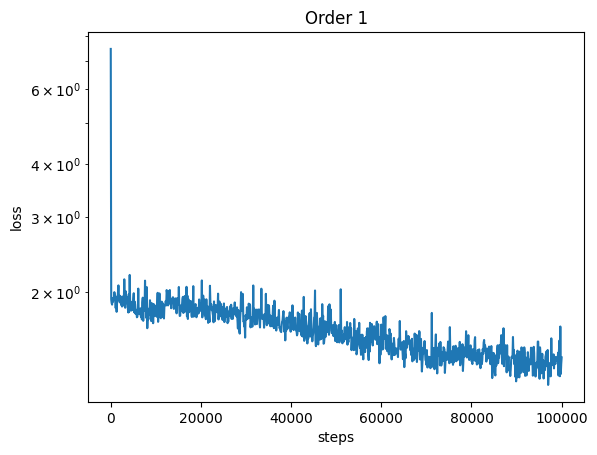

In [16]:
key, key_train = jax.random.split(key, 2)

trained_model_order_1, steps, order_1_losses = train(
    untrained_model, train_samples, val_samples, optim, order=1, key=key_train
)

plt.semilogy(steps, order_1_losses)
plt.title("Order 1")
plt.xlabel("steps")
plt.ylabel("loss")
plt.show()

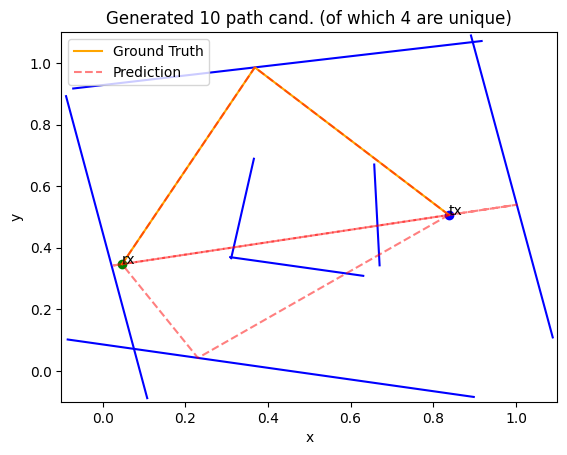

Array(0.6155059, dtype=float32)

In [27]:
key, key_loss_trained = jax.random.split(key, 2)

loss(
    trained_model_order_1, next(train_samples), plot=True, order=1, key=key_loss_trained
)

### Second order paths

As our model does not directly depend on the `order` variable, we
can very easily train it on second-order path candidates instead!

In opposition to the first-order model, the results are far from being
good, and the learning procedure seems to rapidly reach a plateau.
Actually, even though the loss curve seems better, the predicted
path candidates seems be invalid most of the time, which indicates
that their is a failure in the learning process.

Moreover, in somes cases, e.g., when the learning rate is too large,
we observe a *collapse mode* after some steps, where the model just
converge to $F(s,s')=0$.

  0%|          | 0/100000 [00:00<?, ? steps/s]

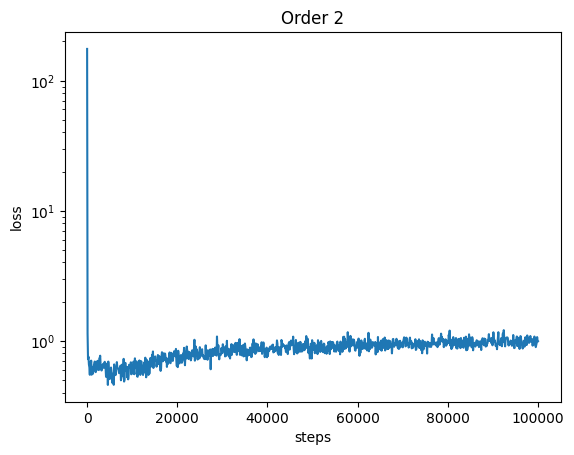

In [18]:
key, key_train = jax.random.split(key, 2)
trained_model_order_2, steps, order_2_losses = train(
    untrained_model, train_samples, val_samples, optim, order=2, key=key_train
)

plt.semilogy(steps, order_2_losses)
plt.title("Order 2")
plt.xlabel("steps")
plt.ylabel("loss")
plt.show()

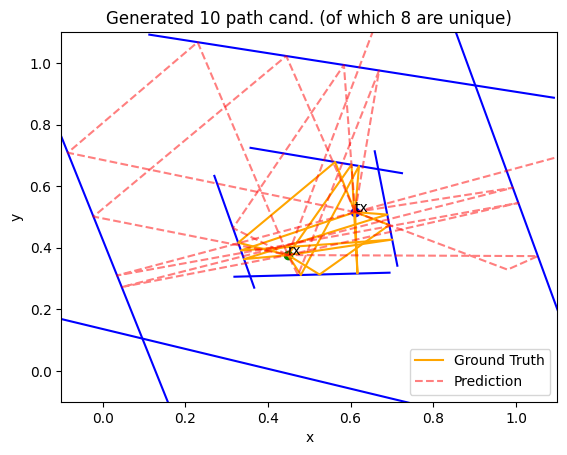

Array(0.23642147, dtype=float32)

In [19]:
# Run this cell multiple times for different results!

key, key_loss_trained = jax.random.split(key, 2)

loss(
    trained_model_order_2, next(train_samples), plot=True, order=2, key=key_loss_trained
)

Alternatively, we could use the `trained_model_order_1` to generate
second-order path candidates, hoping that it generalizes well
on higher orders.

## Inference phase

Once the model has been trained, we can instantiate a complete Machine Learning
model to sample path candidates. In itself, the `Model` class is just a plan
wrapper around the trained `FlowModel` instance, that will call
it repeatedly to generate path candidates of a given size.

In [20]:
model = Model(
    flow=eqx.nn.inference_mode(
        trained_model_order_2
    )  # Here, this is a no-op (just copies the model)
)

In [21]:
# Run this cell multiple times for different results!

key, key_inference = jax.random.split(key, 2)

model(next(train_samples), order=2, key=key_inference)

Array([1, 3], dtype=int32)

=(discussion)
## Discussion

TODO.

Future prospects:
- removing from the training data the scenes that **do not contain any valid path**:
  they are not actually very interesting for our problem, and may have a detrimental impact on the
  learning process as the model will not receive any reward.
- to enhance generalization, we also could think of accumulating the loss on several scenes, rather than one scene at a time;
- and investigate solution that aims to mitigate to impact of sparse reward functions, as in our case.

## Appendix - Training on curated scenes

As suggested in the [discussion](#discussion), for show how the training on a curated training
dataset, with some scenes removed, can help improving the learning process.

Here, the `filter_xys` function just returns `True` if the scene
will at least contain one valid ray path.

In [22]:
def filter_xys(xys: Float[Array, "2+num_walls*2 2"]) -> bool:
    scene = sample_2_scene(xys)

    for _ in scene.all_valid_paths(order=order):
        return True

    return False


curated_train_samples = filter(filter_xys, train_samples)
curated_val_samples = [next(curated_train_samples) for i in range(num_val_samples)]

  0%|          | 0/100000 [00:00<?, ? steps/s]

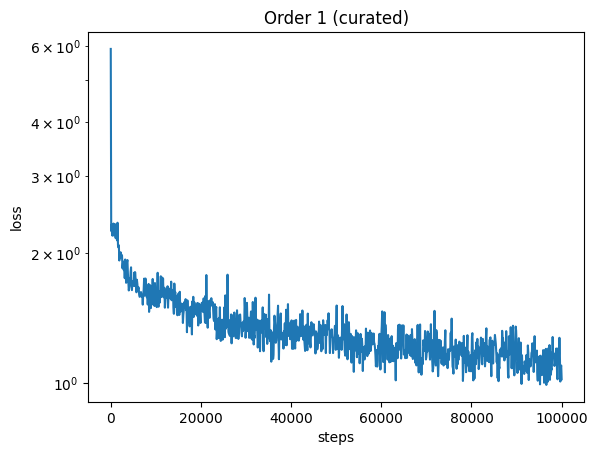

In [23]:
key, key_curated_train = jax.random.split(key, 2)
trained_curated_model, steps, curated_order_1_losses = train(
    untrained_model,
    curated_train_samples,
    curated_val_samples,
    optim,
    order=1,
    key=key_curated_train,
)

plt.semilogy(steps, curated_order_1_losses)
plt.title("Order 1 (curated)")
plt.xlabel("steps")
plt.ylabel("loss")
plt.show()

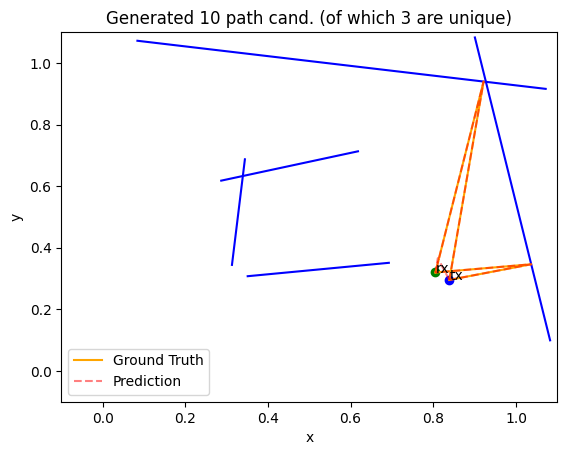

Array(0.15304951, dtype=float32)

In [24]:
key, key_loss_trained = jax.random.split(key, 2)

loss(
    trained_curated_model, next(train_samples), plot=True, order=1, key=key_loss_trained
)

### Losses comparison

Let's end this notebook by comparing the three different learning losses.

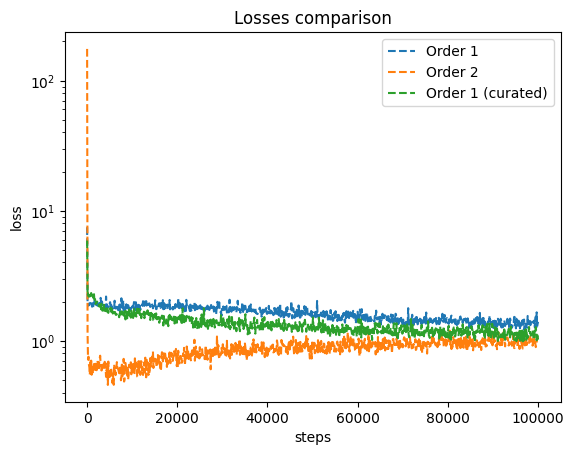

In [25]:
plt.semilogy(steps, order_1_losses, "--", label="Order 1")
plt.semilogy(steps, order_2_losses, "--", label="Order 2")
plt.semilogy(steps, curated_order_1_losses, "--", label="Order 1 (curated)")
plt.title("Losses comparison")
plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.show()